**Image Classification Model Deployment by Mahmudin Rizal (Mahmudinrizal11@gmail.com)**

Klasifikasi pada kasus ini ialah klasifikasi gambar hewan. Dataset didapatkan dari https://www.kaggle.com/madisona/translated-animals10/version/1

In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile,os
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications.inception_v3 import InceptionV3
from urllib.request import urlopen
import warnings
warnings.filterwarnings("ignore")

**Data Preparation**

In [2]:
!pip install -q kaggle

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mahmudinrizal","key":"52618f26c8e1d49480f182d9ab65cb11"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [5]:
!kaggle datasets download -d madisona/translated-animals10

100% 585M/586M [00:15<00:00, 32.6MB/s]
100% 586M/586M [00:15<00:00, 40.2MB/s]


In [6]:
!mkdir animalsdata
!unzip -qq translated-animals10.zip -d animalsdata
!ls animalsdata

animals10


In [7]:
animals_img = ['butterfly', 
               'cat', 
               'chicken',
               'cow',
               'dog',
               'elephant',
               'horse', 
               'sheep',
               'spider', 
               'squirrel']

for animal in animals_img:
    print(f'{animal} images: ', len(os.listdir(f'/content/animalsdata/animals10/raw-img/{animal}')))

butterfly images:  2112
cat images:  1668
chicken images:  3098
cow images:  1866
dog images:  4863
elephant images:  1446
horse images:  2623
sheep images:  1820
spider images:  4821
squirrel images:  1862


In [8]:
try:
  os.mkdir('/content/animalsdata/animals10/train')
  os.mkdir('/content/animalsdata/animals10/test')
  for animal in animals_img:
    os.mkdir(f'/content/animalsdata/animals10/train/{animal}')
    os.mkdir(f'/content/animalsdata/animals10/test/{animal}')
except OSError:
  pass

In [9]:
base_dir = '/content/animalsdata/animals10/raw-img/'

In [10]:
os.listdir(base_dir)

['dog',
 'butterfly',
 'sheep',
 'spider',
 'horse',
 'chicken',
 'elephant',
 'cat',
 'squirrel',
 'cow']

In [11]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

**Image Augmenation and data split**

In [12]:
train_data = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode = 'nearest',
    zoom_range = 0.2,
    validation_split = 0.2 
)
train_data

In [13]:
train_generator = train_data.flow_from_directory(
    base_dir,
    target_size = (150, 150),
    class_mode = 'categorical',
    subset = 'training'
)

validation_generator = train_data.flow_from_directory(
    base_dir,
    target_size = (150, 150),
    class_mode = 'categorical',
    subset = 'validation'
)

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


**Modeling**

In [14]:
tf.keras.backend.clear_session()
ourmodel = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'softmax')
])

In [15]:
ourmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 32)        9

In [16]:
#compile model
ourmodel.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.optimizers.Adam(),
    metrics = ['accuracy']               
)

In [17]:
# callbacks for early stop when reach our target accuracy
accuracy_threshold = 92e-2
class our_callbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if logs.get('accuracy') > accuracy_threshold and logs.get('val_accuracy')> accuracy_threshold:
            print('\nFor Epoch', epoch, '\nAccuracy has reach = %2.2f%%' %(logs['accuracy']*100), 
                  '\nVal Accuracy has reach = %2.2f%%' %(logs['val_accuracy']*100), '.training has been stopped. Continue to the next step')
            self.model.stop_training = True

In [20]:
# train data
history = ourmodel.fit(
    train_generator,
    steps_per_epoch = 200,
    epochs = 25,
    validation_data = validation_generator,
    verbose = 1,
    callbacks = [our_callbacks()]
)

Epoch 1/25
200/200 [==============================] - 88s 442ms/step - loss: 2.1158 - accuracy: 0.2446 - val_loss: 2.0061 - val_accuracy: 0.3047
Epoch 2/25
200/200 [==============================] - 88s 443ms/step - loss: 2.0122 - accuracy: 0.2812 - val_loss: 1.9622 - val_accuracy: 0.3085
Epoch 3/25
200/200 [==============================] - 87s 436ms/step - loss: 1.9431 - accuracy: 0.3208 - val_loss: 1.8650 - val_accuracy: 0.3387
Epoch 4/25
200/200 [==============================] - 89s 444ms/step - loss: 1.8850 - accuracy: 0.3275 - val_loss: 1.8243 - val_accuracy: 0.3593
Epoch 5/25
200/200 [==============================] - 90s 451ms/step - loss: 1.8069 - accuracy: 0.3634 - val_loss: 1.7411 - val_accuracy: 0.3985
Epoch 6/25
200/200 [==============================] - 88s 439ms/step - loss: 1.7414 - accuracy: 0.3913 - val_loss: 1.6956 - val_accuracy: 0.4031
Epoch 7/25
200/200 [==============================] - 89s 446ms/step - loss: 1.6945 - accuracy: 0.4091 - val_loss: 1.6311 - val_ac

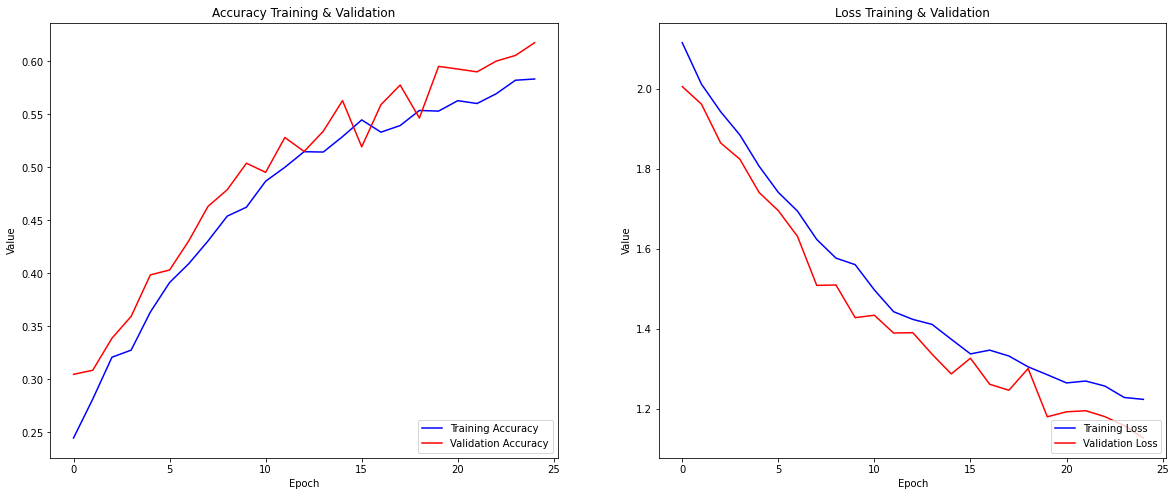

In [21]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Accuracy Training & Validation')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="lower right")


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Loss Training & Validation')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

Karena hasil dari model belum seperti yang diharapkan, selanjutnya akan diterapkan transfer learning guna membantu meningkatkan akurasi dan val akurasi.

**MODEL WITH ResNet152v2**

In [22]:
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152V2

In [23]:
tf.keras.backend.clear_session()

model_RN = tf.keras.models.Sequential([
    ResNet152V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3))),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_RN.layers[0].trainable = False
model_RN.summary()

234561536/234545216 [==============================] - 9s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 5, 5, 2048)        58331648  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dropout (Dropout)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3276864   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 61,610,922
Trainable params: 3,279,274
No

In [24]:
model_RN.compile(optimizer=tf.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [25]:
# train data
history2 = model_RN.fit(
    train_generator,
    epochs = 25,
    validation_data = validation_generator,
    verbose = 1,
    callbacks = [our_callbacks()]
)

Epoch 1/25
655/655 [==============================] - 298s 438ms/step - loss: 0.7579 - accuracy: 0.8035 - val_loss: 0.4516 - val_accuracy: 0.8666
Epoch 2/25
655/655 [==============================] - 282s 431ms/step - loss: 0.4678 - accuracy: 0.8606 - val_loss: 0.4044 - val_accuracy: 0.8773
Epoch 3/25
655/655 [==============================] - 281s 429ms/step - loss: 0.3887 - accuracy: 0.8840 - val_loss: 0.3532 - val_accuracy: 0.8985
Epoch 4/25
655/655 [==============================] - 280s 427ms/step - loss: 0.3462 - accuracy: 0.8919 - val_loss: 0.3269 - val_accuracy: 0.8987
Epoch 5/25
655/655 [==============================] - 280s 427ms/step - loss: 0.3303 - accuracy: 0.8960 - val_loss: 0.3381 - val_accuracy: 0.9023
Epoch 6/25
655/655 [==============================] - 279s 426ms/step - loss: 0.3092 - accuracy: 0.9052 - val_loss: 0.3348 - val_accuracy: 0.9031
Epoch 7/25
655/655 [==============================] - 278s 425ms/step - loss: 0.2926 - accuracy: 0.9090 - val_loss: 0.3248 -

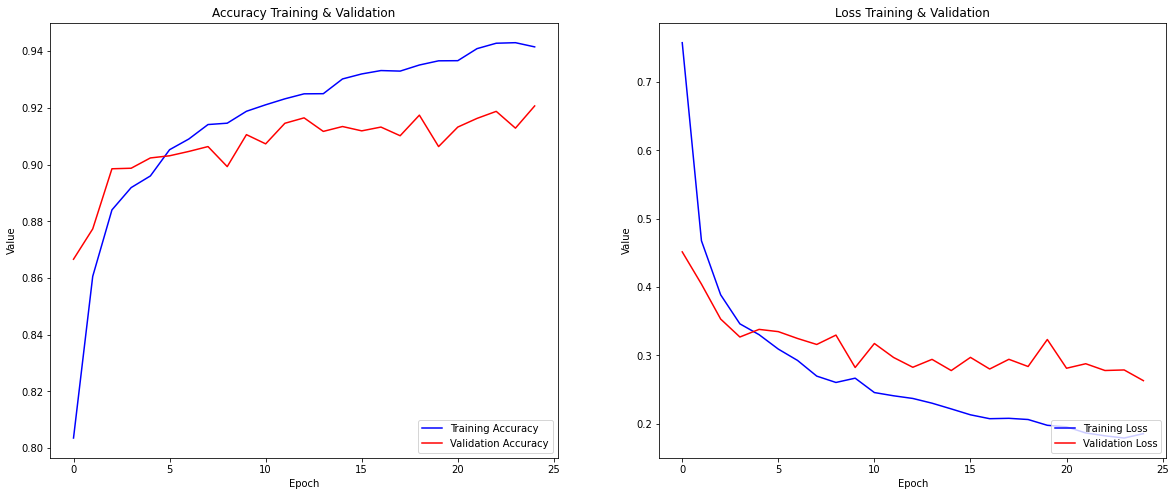

In [32]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Accuracy Training & Validation')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="lower right")


plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss', color='blue')
plt.plot(history2.history['val_loss'], label='Validation Loss', color='red')
plt.title('Loss Training & Validation')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

Dengan bantuan transfer learning Resnet152v2 akurasi dan val akurasinya berhasil mencapai target.

**Mengubah model ke dalam format tflite**

In [34]:
# Konversi model.
converter = tf.lite.TFLiteConverter.from_keras_model(model_RN)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmphi22m5g4/assets


In [35]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)